# Jim's ADL demo

[This repository](https://github.com/jpivarski/analysis-description-language) contains an example language parsed by PLY (a lex-yacc implementation in Python) and interpreted as an abstract syntax tree. Its purpose is to show how these tools make short work of language design and testing— 3 days and less than 3000 lines of code— and also to illustrate the syntactical points I made on Monday and Tuesday with a working language. In principle, this example language is complete enough to test on a real analysis.

In our workshop, I think I got an idea of the problem you're solving: a generic programming language can express signal/control regions and systematic variations, but with too much flexibility— it hides the structure of the analysis. That's why you (both groups) introduced a block structure. However, when you want to compute complex physics objects and candidates formed by combinations of physics objects, the block structure gets unwieldy. I suggested that a functional expression-based syntax with arbitrarily deep nesting would simplify the handling of combinatorics.

The language that I'll be presenting here uses blocks for its control structure and functional expressions to handle physics objects and candidates. It's not unusual for a language to have two fundamentally different types of syntax structures: Python has expressions and statements, C++ has expressions, statements, templated type expressions, preprocessor instructions, and maybe more. Only a few very pure languages (LISP, Haskell, Scala, and Rust) are expression-only.

Although I wrote a fairly complete interpreter, it was written without performance in mind and is likely very slow. This is just to illustrate how the language ought to work; I have ideas about how this should be optimized (using [awkward-arrays](https://github.com/scikit-hep/awkward-array)). Interpreters are quick to write and therefore also quick to change in response to feedback. It does not perform a type-check and it operates on Python objects internally. Another implementation of the same language would use a different data representation.

In [1]:
%matplotlib inline
import numpy
import adl.interpreter

## Histogramming

First and foremost, it's a language for making histograms, or aggregating statistics in general. In the example below, the ADL is quoted in a string, made executable by `adl.interpreter.Run`. To run it, we call it and pass it some variables (only numbers `x` in this case).

In [2]:
run = adl.interpreter.Run("""
count "histogram" by
  regular(100, -5, 5) <- x
""")
run(x = numpy.random.normal(0, 1, 10000));

The `run` object is a container of histograms. We can find the histograms using the names provided in the code.

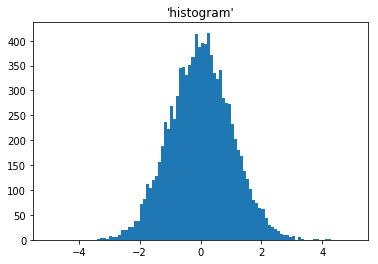

In [3]:
run["histogram"].plot()

Why `count` instead of `histogram`? The `count` primitive just says we want to count something; the binning clauses after `by` say how we want to divide it up. After all, histograms are just binned counting.

In [4]:
run = adl.interpreter.Run("""
count "one-bin histogram"
""")
run(x = numpy.random.normal(0, 1, 10000));

In [5]:
run["one-bin histogram"]

<Count 'one-bin histogram': 10000 +- 100.0>

In [6]:
run = adl.interpreter.Run("""
count "2D histogram" by
  regular(5, -5, 5)         <- x
  variable(-5, -1, 0, 1, 5) <- y
""")
run(x = numpy.random.normal(0, 1, 10000),
    y = numpy.random.normal(0, 1, 10000));

In [7]:
for i in range(-1, 6):
    for j in range(-1, 6):
        print(run["2D histogram", i, j])

<Count '2D histogram', 'underflow', 'underflow': 0 +- 0.0>
<Count '2D histogram', 'underflow', 0: 0 +- 0.0>
<Count '2D histogram', 'underflow', 1: 0 +- 0.0>
<Count '2D histogram', 'underflow', 2: 0 +- 0.0>
<Count '2D histogram', 'underflow', 3: 0 +- 0.0>
<Count '2D histogram', 'underflow', 'overflow': 0 +- 0.0>
<Count '2D histogram', 'underflow', 'overflow': 0 +- 0.0>
<Count '2D histogram', 0, 'underflow': 0 +- 0.0>
<Count '2D histogram', 0, 0: 2 +- 1.4142135623730951>
<Count '2D histogram', 0, 1: 4 +- 2.0>
<Count '2D histogram', 0, 2: 7 +- 2.6457513110645907>
<Count '2D histogram', 0, 3: 3 +- 1.7320508075688772>
<Count '2D histogram', 0, 'overflow': 0 +- 0.0>
<Count '2D histogram', 0, 'overflow': 0 +- 0.0>
<Count '2D histogram', 1, 'underflow': 0 +- 0.0>
<Count '2D histogram', 1, 0: 275 +- 16.583123951777>
<Count '2D histogram', 1, 1: 547 +- 23.388031127053>
<Count '2D histogram', 1, 2: 575 +- 23.979157616563597>
<Count '2D histogram', 1, 3: 258 +- 16.06237840420901>
<Count '2D histog

There's no fundamental distinction between 1D, 2D, or nD histograms; they're all just 1D histograms of 1D histograms— a block of grid values to be sliced and projected. Several histogramming packages are moving this way (such as [histbook](https://github.com/scikit-hep/histbook), [Boost.Histogram](https://github.com/HDembinski/histogram), and [ROOT 7](https://root.cern.ch/root-7)).

Here's a slice: bin 3 of the first axis is a 1D histogram (with variable-sized binning; see the code).

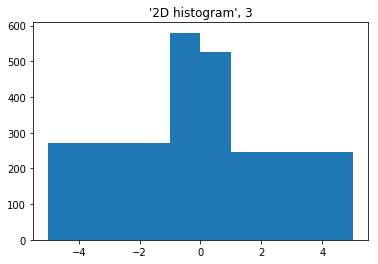

In [8]:
run["2D histogram", 3].plot()

An analysis includes many histograms, so an ADL source file would contain many such `count` statements and the resulting object would hold them all together in an organized way. (This could simplify the configuration of many-histogram fitters like HistFactory or Combiner.)

In [9]:
run = adl.interpreter.Run("""
count "first" by
  regular(100, -5, 5) <- x

count "second" by
  regular(100, 0, 5) <- x**2
""")
run(x = numpy.random.normal(0, 1, 10000));

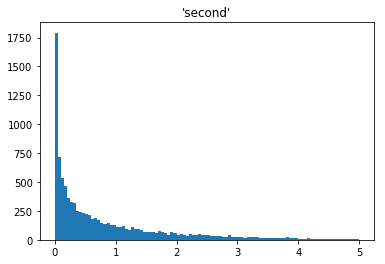

In [10]:
run["second"].plot()

## Other statistical aggregations

For other types of aggregations, `count` can be replaced by `sum`, `profile`, or `fraction`.

In [11]:
run = adl.interpreter.Run("""
count    "first"       # no quantity
sum      "second" x    # add up x
profile  "third"  x    # compute mean and variance of x
fraction "fourth" p    # compute fraction for which p is true
""")
run(x = [1, 2, 3, 4, 5], p = [False, False, True, True, False]);

In [12]:
run["first"]

<Count 'first': 5 +- 2.23606797749979>

In [13]:
run["second"]

<Sum 'second': 15.0>

In [14]:
run["third"]

<Profile 'third': 3.0 +- 0.6324555320336759>

In [15]:
run["fourth"]

<Fraction 'fourth': 0.4 +- 0.4680694638641432>

In [16]:
run["fourth"].error(method="wilson")

0.7857225398615839

Of course, they can all be weighted.

In [17]:
run = adl.interpreter.Run("""
count "histogram" by
  regular(100, -5, 5) <- x
  weight x**2
""")
run(x = numpy.random.normal(0, 1, 10000));

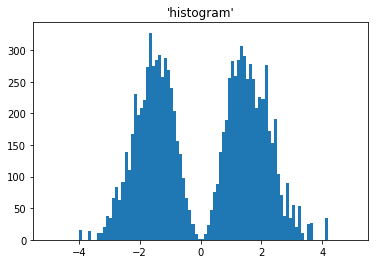

In [18]:
run["histogram"].plot()

## Signal and control regions

So far what we've seen could almost be done with a standard histogramming package. The reason we want a language is to simplify the organization of many control regions and systematic variations. To define groups of event selections, use the `region` keyword.

In [30]:
x = numpy.random.normal(0, 1, 10000)
y = x + numpy.random.normal(0, 0.1, 10000)

run = adl.interpreter.Run("""
region "signal": x >= 0          # may be a complex predicate with and, or, not
{
  count "histogram" by
    regular(100, -5, 5) <- y
}

region "control": x < 0
{
  count "histogram" by
    regular(100, -5, 5) <- y
}
""")
run(x = x, y = y);

The histograms are nested within each region.

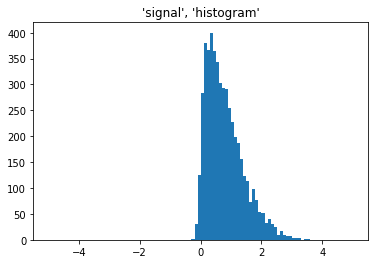

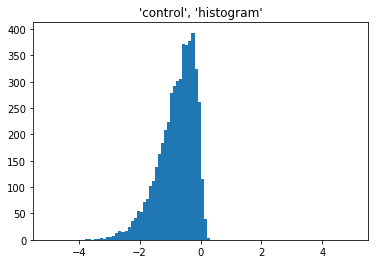

In [22]:
run["signal", "histogram"].plot()
run["control", "histogram"].plot()

The above example (and a lot of physics analyses!) involves dangerous duplication: we want to see the same histograms in all regions to compare them, but the names, binning, and fill expressions have to be kept the same by hand. To fix this problem, the `region` keyword can take multiple named predicates.

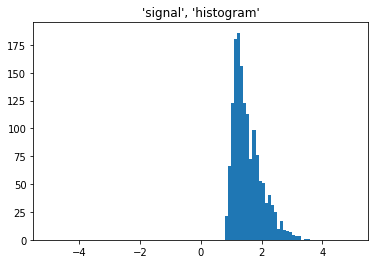

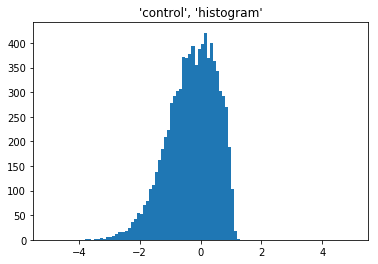

In [25]:
run = adl.interpreter.Run("""
region
  "signal": x >= 1      # must be separated by newlines or semicolons
  "control": x < 1
{
  count "histogram" by
    regular(100, -5, 5) <- y
}
""")
run(x = x, y = y);

run["signal", "histogram"].plot()
run["control", "histogram"].plot()

Now imagine an analysis with a dozens of regions and hundreds of histograms in each. We only need to write the histogram parameters once (as above) inside a `region` with all the predicates listed. If we change a histogram, we don't have to change its partners in a dozen different places.

If the regions represent non-overlapping rectangles, like the bins of a histogram, then we can use the same axis syntax to generate them. This avoids copy-paste errors in the predicates themselves.

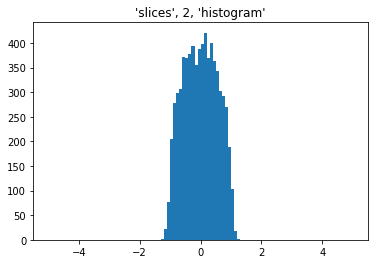

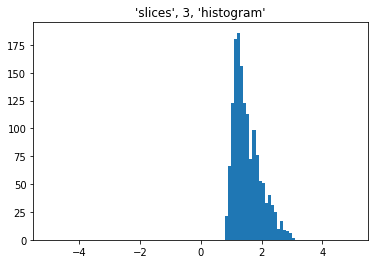

In [26]:
run = adl.interpreter.Run("""
region "slices": true by      # predicate is "true" because all subdivision happens in the binning
  regular(5, -5, 5) <- x
{
  count "histogram" by
    regular(100, -5, 5) <- y
}
""")
run(x = x, y = y);

run["slices", 2, "histogram"].plot()
run["slices", 3, "histogram"].plot()

Now that we're defining rectangular regions and the bins of histograms using the same mechanism and extracting them using the same mechanism: strings for named regions and integers for sequential slices.

In [27]:
run["slices", 3, "histogram", 75]

<Count 'slices', 3, 'histogram', 75: 10 +- 3.1622776601683795>

And of course, `regions` can be nested. A particularly complex analysis might need that. (This also is the reason for the curly brackets, to make the structure clear.)

In [31]:
run = adl.interpreter.Run("""
region "slices": true by
  regular(5, -5, 5) <- x
{
  region "one":   y > -3
         "two":   y >  0
         "three": y >  3
  {
    count "counter"
  }
}
""")
run(x = x, y = y);

for i in range(-1, 6):
    for j in "one", "two", "three":
        print(run["slices", i, j, "counter"])

<Count 'slices', 'underflow', 'one', 'counter': 0 +- 0.0>
<Count 'slices', 'underflow', 'two', 'counter': 0 +- 0.0>
<Count 'slices', 'underflow', 'three', 'counter': 0 +- 0.0>
<Count 'slices', 0, 'one', 'counter': 2 +- 1.4142135623730951>
<Count 'slices', 0, 'two', 'counter': 0 +- 0.0>
<Count 'slices', 0, 'three', 'counter': 0 +- 0.0>
<Count 'slices', 1, 'one', 'counter': 1541 +- 39.25557285278104>
<Count 'slices', 1, 'two', 'counter': 0 +- 0.0>
<Count 'slices', 1, 'three', 'counter': 0 +- 0.0>
<Count 'slices', 2, 'one', 'counter': 6873 +- 82.90355842785037>
<Count 'slices', 2, 'two', 'counter': 3473 +- 58.93216439263028>
<Count 'slices', 2, 'three', 'counter': 0 +- 0.0>
<Count 'slices', 3, 'one', 'counter': 1558 +- 39.4715087119811>
<Count 'slices', 3, 'two', 'counter': 1558 +- 39.4715087119811>
<Count 'slices', 3, 'three', 'counter': 1 +- 1.0>
<Count 'slices', 4, 'one', 'counter': 12 +- 3.4641016151377544>
<Count 'slices', 4, 'two', 'counter': 12 +- 3.4641016151377544>
<Count 'slices

## Systematic variations

Another aspect of physics analysis that often involves code duplication is varying quantities to gauge systematic errors. We want those in some auto-duplicating structure as well.